<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

### CONTENT INDEX

1. SET-UP
  - Report
2. EDA
  - Data types
  - Descriptive statistics
    - Plots, summary statistics 
  - Relationships between variables 
  - other...
  - Conclusion 
3. DATA SPLITTING
4. Data preprocessing
  - Missing data analysis
  - Outlier detection analysis
  - Data imputing
  - Class imbalance
5. FEATURE ANALYSIS
  - Feature transformation
  - Feature selection
6. MODELLING
  - Non-optimized training
  - Optimized training
  - Conclusions

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
from collections import defaultdict
import math
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [2]:
from utilities_functions import *

If u make a change to utilities_function u may need to restart the kernel to use the latest versions. This is too tedious. There must be another way.

In [3]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [4]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [5]:
file_path ="./dataset/dynamic_dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head()

In [7]:
df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names

In [ ]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
print("\nColumn Names:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes.value_counts())

### Notebook-level constants

In [6]:
RANDOM_STATE = 99
ONLY_NUMERICAL_COLUMNS = df.select_dtypes(include='number')


### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Data Type Distribution

In [ ]:
# Get the data type distribution
dtype_counts = df.dtypes.value_counts()
dtype_counts

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [ ]:
df_onlyCols = df.select_dtypes(include=["object"]).columns
df_onlyCols

## Summary Statistics Overview

## Histograms


In [ ]:
# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

In [ ]:
# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [ ]:
numeric_cols = df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")

## Categorical Features

In [ ]:
#Statistical summary for categorical features
df.describe(include=["object", "category", "bool"])

In [ ]:
print(df[['Hash', 'Category', 'Family']].head())

Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [ ]:
# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts = df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")


A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [8]:
df = df.drop(columns=['Hash'])
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''

'\nThe Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.\nIt serves as an identifier for each malware sample. Including this column in modeling\nwould not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are\nsensitive to high-cardinality categorical features.\n <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the \n  argumentation in a text cell not in this type of comments. <<<>>>\n'

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [ ]:
print(df["reboot"].value_counts())

The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

In [ ]:
#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [ ]:
reboot_means = df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Family

In [ ]:
#How many categories each family belongs to
df.groupby("Family")["Category"].nunique().sort_values(ascending=False)

Almost every family is either unknown or unique


In [378]:
# <<<Error: NameError: name 'family_to_category' is not defined>>> (this Irina's code; copied from Argentinan guy's notebook)
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [ ]:
df[df["Family"] == "<unknown>"]["Category"].value_counts()

In [ ]:
# Step 1: Count unique families per category
family_amount = df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = df[df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)

In [ ]:
unknown_count = (df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")


Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

# DATA SPLITTING
### TO BE DONE
- Statistical analysis of this

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

In [9]:
X_category, y_category = get_X_y(df, "Category", ["Family"])

Before we continue with the split, lets advance some for the time we get to the encoding process. 
We are gonna check how many categorical variables are present in each matrix

In [10]:
X_category.select_dtypes(include=["object"])

,Reboot
0,before
1,before
2,before
3,before
4,before
...,...
53434,before
53435,before
53436,before
53437,before


In [ ]:
y_category

Also object!
Lets get back to the splitting!

In [11]:
X_category_train, X_category_val, X_category_test, y_category_train, y_category_val, y_category_test = get_split_data(X_category, y_category, train_size=0.8, validation_size=0.1, test_size=0.1, random_state=99)

X_category_train.shape, X_category_val.shape, X_category_test.shape, y_category_train.shape, y_category_val.shape, y_category_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

## FEATURE ENCODING

#### Encoding the X matrices (one-hot encoder)
Lets fit the X encoder for the object column (reboot)

In [12]:
X_category_train_encoded, X_category_val_encoded, X_category_test_encoded = get_X_sets_encoded(X_category_train, X_category_val, X_category_test)

Lets visualize the results of the encoding...

In [ ]:
X_category_train_encoded

In [ ]:
X_category_val_encoded

In [ ]:
X_category_test_encoded

Awesome, the X matrices are all set now. Lets finally encode the target variable (which we saw in the split process is of dtype: object)
#### Encoding y matrix (labeller encoding) 
We know our models needs the target variable to be numerical. Lets transform this series object then!
We will fit the encoder in the training set, and extend it to the other sets

In [13]:
y_category_train_encoded, y_category_val_encoded, y_category_test_encoded = get_y_sets_encoded(y_category_train, y_category_val, y_category_test)

One more time, let's visualize the results

In [14]:
y_category_train_encoded, "-"*30,  y_category_val_encoded, "-"*30, y_category_test_encoded, 

(48143     8
 10388     0
 11029     0
 36609     6
 26413    13
          ..
 42697    12
 36008     6
 46265     8
 23587     6
 29313     8
 Length: 42751, dtype: int64,
 '------------------------------',
 18288    6
 40648    6
 8718     0
 5961     0
 32688    8
         ..
 20920    6
 33656    3
 32607    8
 8923     0
 38099    6
 Length: 5344, dtype: int64,
 '------------------------------',
 28550    13
 43091    12
 8287      0
 47969     8
 29839     8
          ..
 53065     4
 49176     5
 30395     8
 4491      0
 2304      0
 Length: 5344, dtype: int64)

<hr>

# DATA PREPROCESSING

<hr>

# FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model

INDEX OF THIS SECTION:
- Feature transformation
- Feature engineering
- Feature selection


QUESTIONS FOR THIS SECTION

## FEATURE TRANSFORMATION

- Binning
- Interaction terms

QUESTIONS FOR THIS SUBECTION
- Where can we do binning here?

## FEATURE ENGINEERING
- Domain-specific features

NOTE: This requires further understanding of the concepts around our problem's context. This will be deferred for a second iteration.

## FEATURE SELECTION
- Analyze correlation and low-variances


#### 1.1) Eliminating low-variances features
We will start off feature selection by analyzing the variables that have low variances. Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [15]:
original_number_of_features = df.shape[1]
zero_variance_features = ONLY_NUMERICAL_COLUMNS.std() == 0
if zero_variance_features.any():
    print("Zero-variance features found:")
    print(zero_variance_features[zero_variance_features].index)
    df.drop(columns=zero_variance_features[zero_variance_features].index, inplace=True)
    print(f"Removed {original_number_of_features - df.shape[1]} features with zero variance")
    ONLY_NUMERICAL_COLUMNS = df.select_dtypes(include='number') #updating global variable
else:
    print("No zero-variance features found.")

Zero-variance features found:
Index(['Memory_SwapPssDirty', 'Memory_AssetManagers',
       'API_Process_android.os.Process_start',
       'API_JavaNativeInterface_java.lang.Runtime_loadLibrary',
       'API_WebView_android.webkit.WebView_postWebMessage',
       'API_WebView_android.webkit.WebView_savePassword',
       'API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword',
       'API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword',
       'API_Database_android.database.sqlite.SQLiteDatabase_create',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstalledModules',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstalledPackages',
       'API_Network_org.apache.http.impl.client.AbstractHttpClient_execute',
       'API_Network_com.android.okhttp.internal.http.HttpURLConnectio

Lets focus on features with too few variance

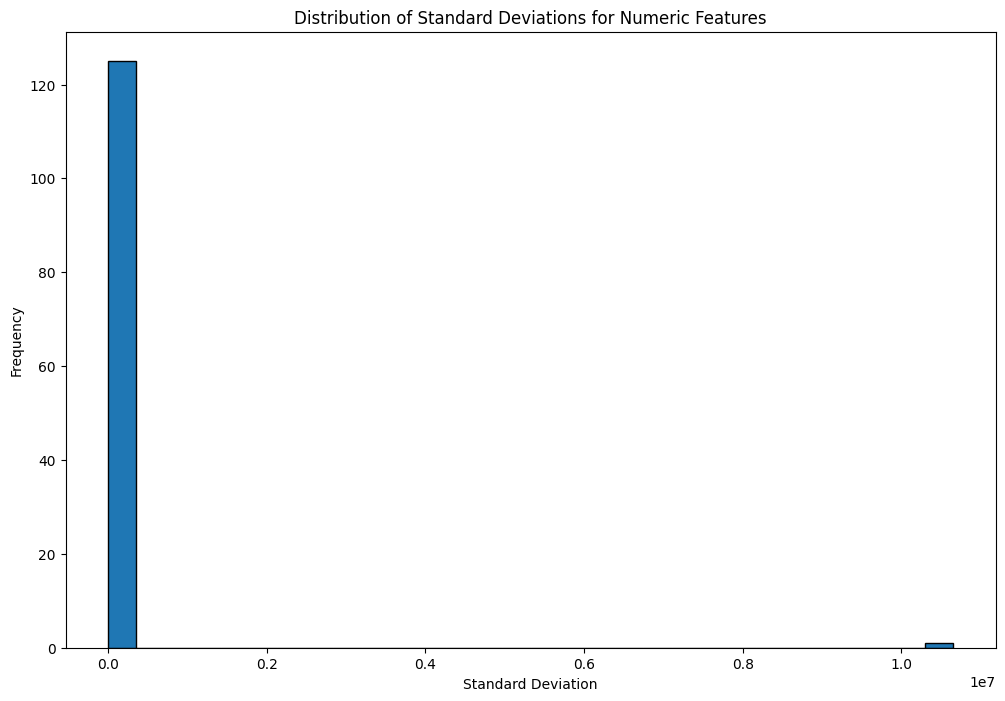

In [16]:
standard_deviations = ONLY_NUMERICAL_COLUMNS.std()
plt.figure(figsize=(12, 8))
plt.hist(standard_deviations, bins=30, edgecolor='black')
plt.title('Distribution of Standard Deviations for Numeric Features')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.show()

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

In [ ]:
STD_THRESHOLD = .4

In [ ]:
cols_to_keep = standard_deviations[(standard_deviations < STD_THRESHOLD)].index
print(f"Removed {len(standard_deviations) - len(cols_to_keep)} features with low variance")

df = df[cols_to_keep]
df.shape


#### 1.2) Eliminating highly correlated feature
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

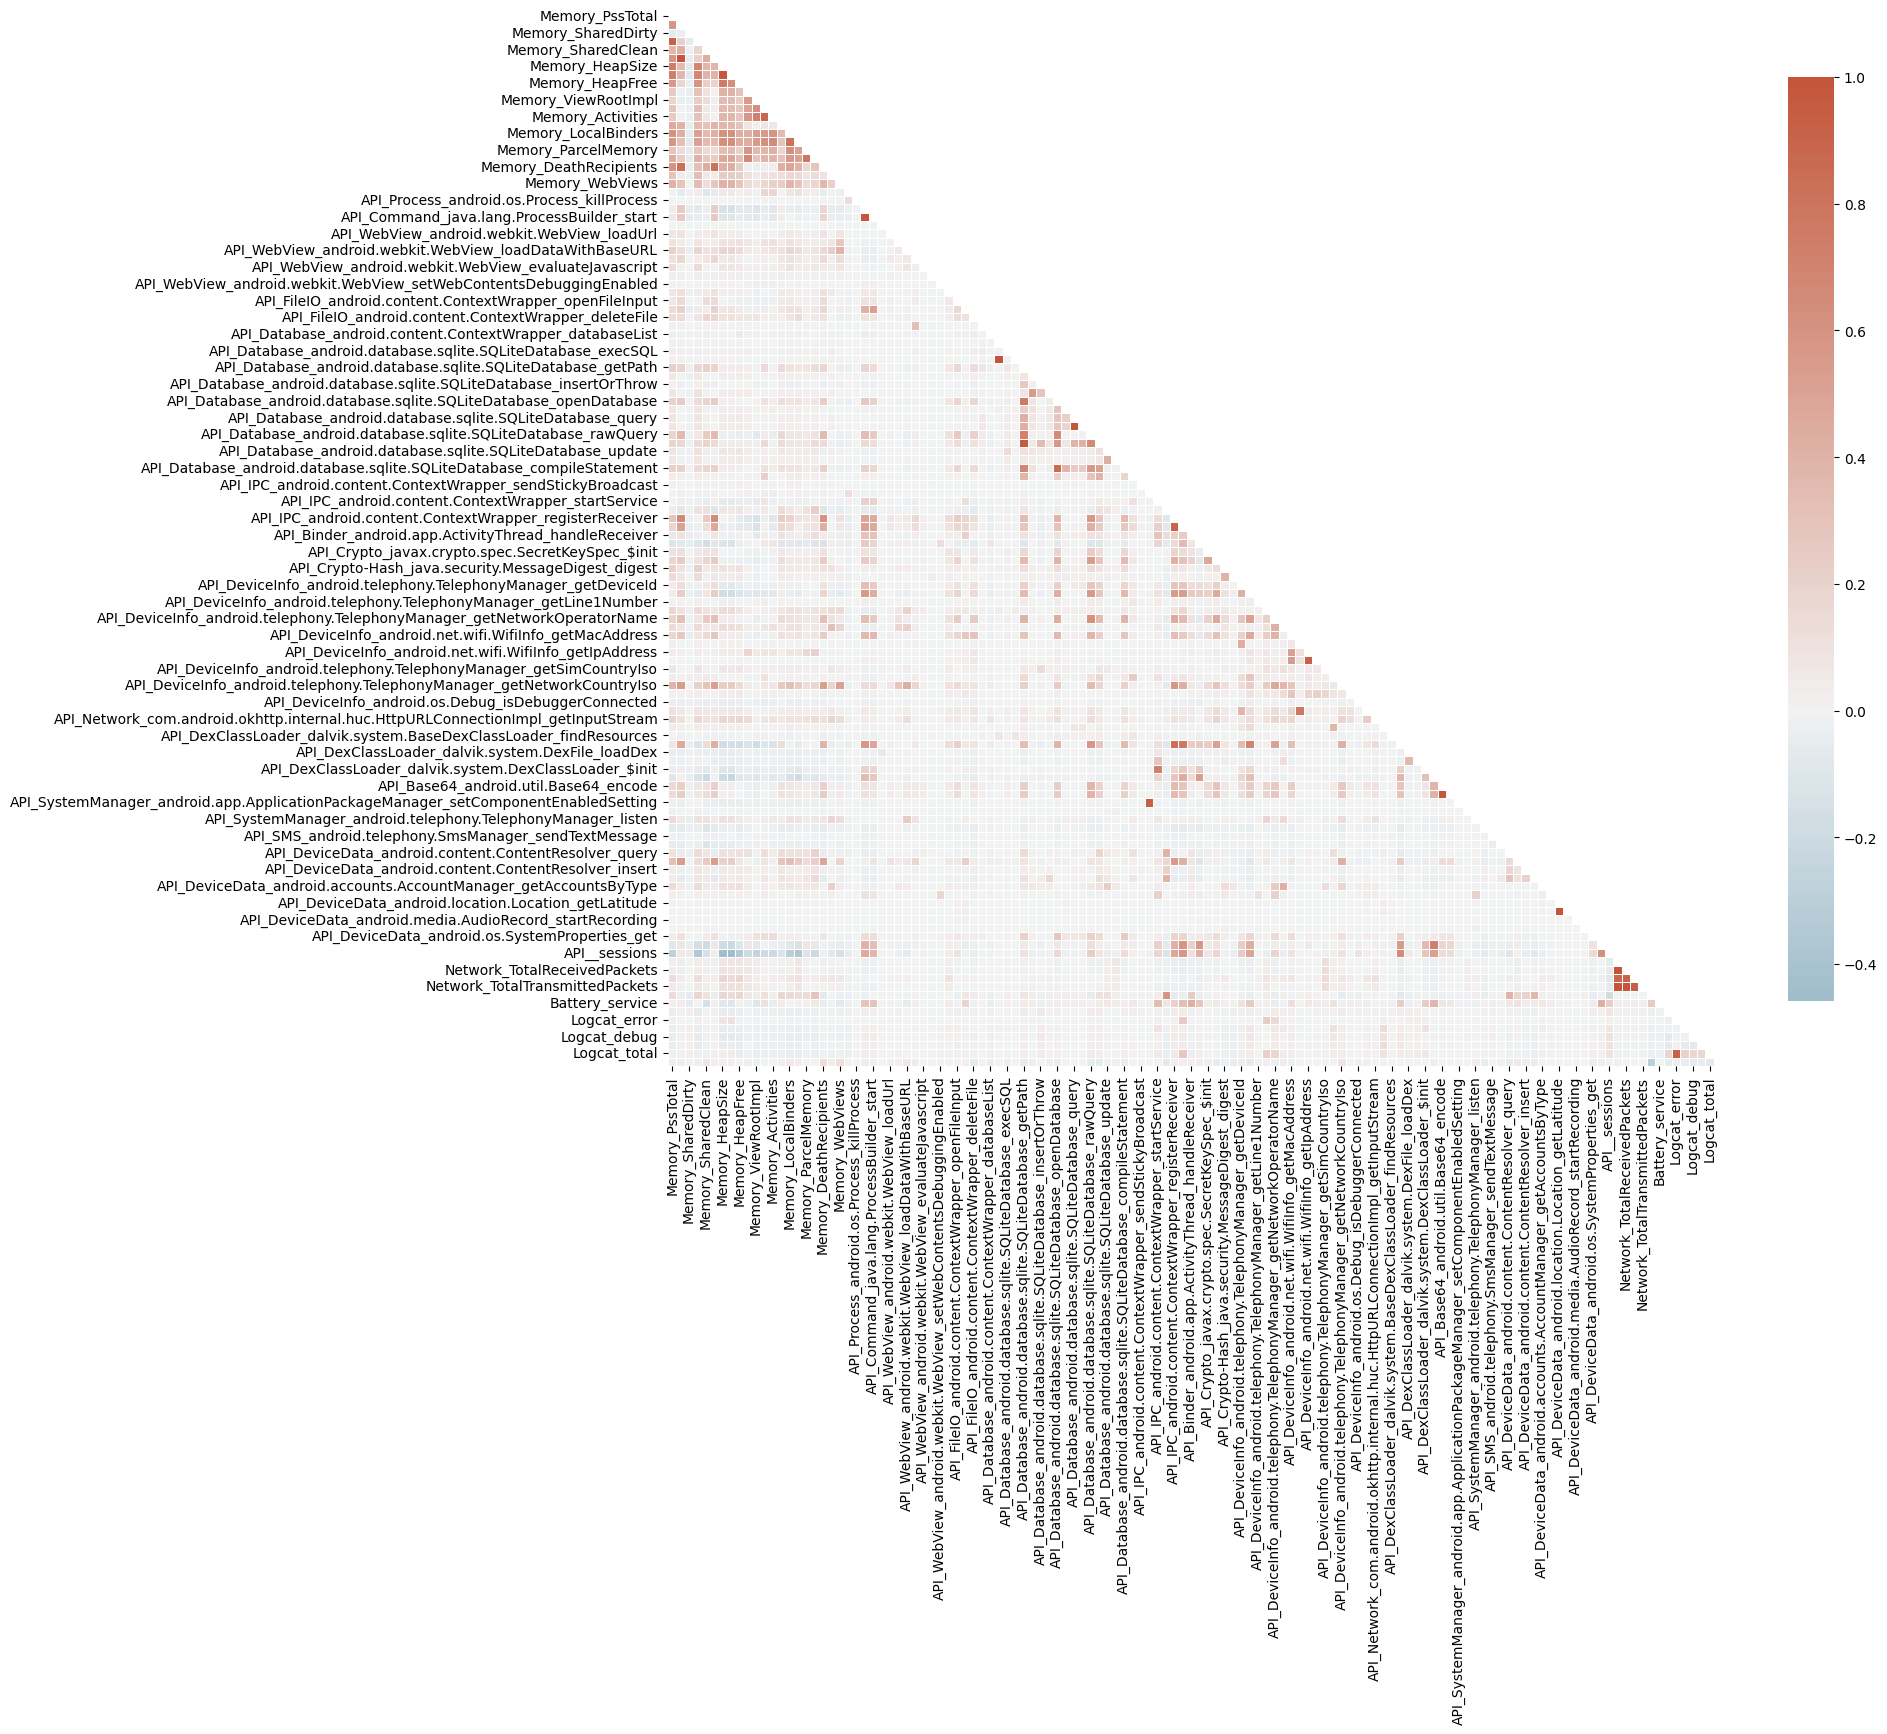

In [27]:
compute_correlation_matrix((17, 15), ONLY_NUMERICAL_COLUMNS)

In [ ]:
number_of_features = ONLY_NUMERICAL_COLUMNS.shape[1]

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.

Well, thats a lot to digest! Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 



$$
VIF_i = \frac{1}{1 - R_i^2}
$$


You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [32]:

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Iteratively remove features with high VIF (threshold = 10)
def remove_high_vif_features(df, threshold=10):
    number_of_iterations = 0
    while True:
        number_of_iterations += 1
        vif_data = calculate_vif(df)
        print(f"VIF computed for iteration {number_of_iterations}:")
        max_vif = vif_data["VIF"].max()
        if max_vif < threshold:
            break
        feature_to_drop = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        df.drop(columns=[feature_to_drop], inplace=True)
        print(f"Dropped: {feature_to_drop}")
    return df

In [ ]:
remove_high_vif_features(ONLY_NUMERICAL_COLUMNS, 10)

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF computed for iteration 1:
Dropped: API_Database_android.content.ContextWrapper_deleteDatabase


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF computed for iteration 2:
Dropped: Logcat_info
VIF computed for iteration 3:
Dropped: Memory_HeapSize


In [ ]:
# Run this whenever u want to eliminate the correlated features 
# for correlated_feature in vif_data["Feature"]:
#   df.drop(columns=[correlated_feature], inplace=True)

There seems to be some clear signs of correlation. However, for the first iteration we are going to be conservative and not remove them (for now; I want to further understand hows it possible for VIF to be inf). Note however, that some of the correlations show seem to make a lot of sense (e.g: Network_TotalReceivedBytes, Network_TotalTransmittedBytes)

### Questions
- What other encoders could be useful?

## DATA CLEANING

INDEX FOR THIS SECTION:
  - Handling duplicate rules
  - Handling outliers
  - Handling missing value 


QUESTIONS FOR THIS SECTION
- Are there not more sophisticated outlier detections methods?
- Ask matteo how to deal with handling outliers with many features

#### Handling Duplicate Values

In [ ]:
df.duplicated().sum()

No duplicate values founds, thus, no further intervetion is requried.

#### Handling Outliers

Now lets remove all outliers. Outliers are records that for a given feature its values is significanlty deviated from its centrality values (for our current example, we'll set the threshold as 3 * IQR)

In [ ]:
df["API_DeviceData_android.content.ContentResolver_query"].hist()

In [ ]:
df["API_DeviceData_android.content.ContentResolver_query"].describe()

In [ ]:
outliers_removed_df = df.copy() # Make a copy (debuggin purporses, will be set to just df eventually)
for col in df.select_dtypes(include='number').columns:
      Q1 = df[col].quantile(0.25)
      Q3 = df[col].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 3 * IQR
      upper_bound = Q3 + 3 * IQR
      outliers_removed_df = outliers_removed_df[(outliers_removed_df[col] >= lower_bound) & (outliers_removed_df[col] <= upper_bound)]
print(f"Removed {len(df) - len(outliers_removed_df)} outliers")

The reason why we are observing such dramatic effect on the amount of eliminated outliers is due to the fact that we are being too strict expecting all rows to have not a single feature containing an outlier in its column. This is way too restrictive. We need to find a better way. 

#### Eliminating empty values

In [ ]:
df_shape_before_elimination = df.shape

In [ ]:
sum(df.isna().sum().tolist())

We dont have **null** values in our dataset but that does not mean we do not have **empty** values. The dataset provider may have encoded this empty values with inf, -1, or other non-sensical value (with respect to the treated column). These valuesa re referred as 'sentinel values'
 Let's look for such values, let us start first with columns of dtype = "object".

#### Categorical variables

In [ ]:
columns_object = df.select_dtypes(include=["object"]).columns
columns_object

CATEGORY

In [ ]:
df["Category"].value_counts()

No_category needs to clearly be deleted as it represents missing values in that area. Zero_Day needs also to be deleted due to its high cardinality with family variably (please, someone who read the paper explain this in better detail)

In [ ]:
original_amount_rows = df.shape[0]
df = df[(df["Category"] != "No_Category") & (df["Category"] != "Zero_Day")]
new_amount_rows = df.shape[0]
print(f"Removed {original_amount_rows - new_amount_rows} rows with empty values for category")

FAMILY

In [ ]:
df["Family"].value_counts().to_dict()

We can see there are some families values marked with  '<unknown>'. They shall be deleted.

In [ ]:
original_amount_rows = df.shape[0]
df = df[df["Family"] != "<unknown>"]
new_amount_rows = df.shape[0]
print(f"Removed {original_amount_rows - new_amount_rows} rows with empty values for family")

REBOOT

In [ ]:
df["Reboot"].value_counts()

Good, let's move on to numerical variables

#### Numerical Variables

Analyzing sentinel values for all possible numerical variables (fede's)

In [ ]:
has_inf = df.isin([np.inf, -np.inf]).any().any()
print("Contains inf:", has_inf)

The first .any() checks each column to see if any value in that column is True.

The second .any() checks across all columns to see if any column contained a True.

### Removing missing values, conclusion

In [ ]:
print(f"Removed {df_shape_before_elimination - df.shape[0]} rows with empty values")

## Feature Scaling

In [ ]:
# Function to determine if a feature needs standardization or normalization
def determine_scaling_method(feature_series):
    """
    Determine whether a feature should be standardized or normalized based on its characteristics.
    
    Args:
        feature_series: Pandas Series containing the feature values
        
    Returns:
        str: 'standardize', 'normalize', or 'none'
    """
    # Skip if all values are the same (zero variance)
    if feature_series.std() == 0:
        return 'none'
    
    # Check for outliers using IQR method
    Q1 = feature_series.quantile(0.25)
    Q3 = feature_series.quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = 1.5 * IQR
    has_outliers = ((feature_series < (Q1 - outlier_threshold)) | 
                    (feature_series > (Q3 + outlier_threshold))).any()
    
    # Check for normality using skewness
    skewness = abs(stats.skew(feature_series.dropna()))
    is_skewed = skewness > 1.0  # Threshold for significant skewness
    
    # Decision logic
    if has_outliers:
        return 'standardize'  # Standardization handles outliers better
    elif is_skewed:
        return 'normalize'    # Normalization is better for non-normal distributions
    else:
        return 'standardize'  # Default to standardization for most ML algorithms

# Get numerical columns (excluding one-hot encoded columns)
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Determine scaling method for each feature
scaling_methods = {}
for col in numerical_cols:
    scaling_methods[col] = determine_scaling_method(df[col])

# Count of each scaling method
method_counts = pd.Series(scaling_methods).value_counts()
print("Scaling methods distribution:")
print(method_counts)

# Create lists for each scaling method
standardize_cols = [col for col, method in scaling_methods.items() if method == 'standardize']
normalize_cols = [col for col, method in scaling_methods.items() if method == 'normalize']
no_scaling_cols = [col for col, method in scaling_methods.items() if method == 'none']

print(f"\nFeatures to standardize: {len(standardize_cols)}")
print(f"Features to normalize: {len(normalize_cols)}")
print(f"Features requiring no scaling: {len(no_scaling_cols)}")

# Apply the transformations
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Create a copy of the dataframe to avoid warnings
df_scaled = df.copy()

# Apply standardization
if standardize_cols:
    df_scaled[standardize_cols] = scaler_standard.fit_transform(df[standardize_cols])

# Apply normalization
if normalize_cols:
    df_scaled[normalize_cols] = scaler_minmax.fit_transform(df[normalize_cols])

# Visualize the effect of scaling on a few features
def plot_before_after_scaling(original_df, scaled_df, features, n_features=4):
    """Plot histograms before and after scaling for selected features."""
    # Select a subset of features if there are too many
    if len(features) > n_features:
        features = np.random.choice(features, n_features, replace=False)
    
    fig, axes = plt.subplots(len(features), 2, figsize=(12, 3*len(features)))
    
    for i, feature in enumerate(features):
        # Original distribution
        sns.histplot(original_df[feature], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Original: {feature}')
        
        # Scaled distribution
        sns.histplot(scaled_df[feature], kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Scaled: {feature}')
    
    plt.tight_layout()
    plt.show()

# Plot examples of standardized features
if standardize_cols:
    print("\nExamples of standardized features:")
    plot_before_after_scaling(df, df_scaled, standardize_cols)

# Plot examples of normalized features
if normalize_cols:
    print("\nExamples of normalized features:")
    plot_before_after_scaling(df, df_scaled, normalize_cols)

print("\nScaling complete! The dataset is now ready for modeling.")

THIS CONTAINS DATA LEAKAGE CAUSE UR FITTING TO ALL SETS THE SAME STANDARIZATION. THIS NEEDS TO BE CORRECTED. ALSO, IT IS NOT TOLERABLE TO WRITE THIS SORT OF CHATGPT COPY AND PASTE WITHOUT EXPLANATIONS. IT CLUTTERS THE CODEBASE.

# MODELLING

- QUESTION ON THIS SECTION
   - How can statistical measurement help on the split?
- TBD (to be done)
   -  x

## Automatic Feature Selection
Lets briefly extend our feature selection process:

### QUESTIONS
- Can this part not be done in feature engineering?
### TBD (things to be done)
- Read more about boruta

#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses.



In [14]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10)

In [ ]:
# Train logistic regression model with L1 penalty
model.fit(X_category_train_encoded, y_category_train_encoded)

# Get the coefficients of the trained model
coefficients = model.coef_
coefficients

In [ ]:
predictivePowerVariables = set()
for i in range(len(coefficients[0])):
      if abs(coefficients[0][i]) > 0:
            predictivePowerVariables.add(X_category_train_encoded.columns[i])
excludedVariables = set(X_category_train_encoded.columns) - predictivePowerVariables
predictivePowerVariables, "-"*30, f"Number of predictive power variables: {len(predictivePowerVariables)}", "-"*30, excludedVariables, "-"*30, f"Number of excluded variables: {len(excludedVariables)}"

#### BORUTA

Read about: 1.13.4.2. [https://scikit-learn.org/stable/modules/feature_selection.html#:~:text=1.13.4.2.%20Tree%2Dbased%20feature%20selection,-%23] (Tree-based feature selection)

In [15]:
rf = RandomForestClassifier(
    n_estimators=100,    
    n_jobs=-1, # multithreading
    class_weight='balanced',
    random_state=RANDOM_STATE
)

In [ ]:
boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=RANDOM_STATE,
    max_iter=10
)
# Fit Boruta on your training data.
boruta_selector.fit(X_category_train_encoded.values, y_category_train_encoded.values)
selected_mask = boruta_selector.support_

In [ ]:
selected_features = set(X_category_train_encoded.columns[selected_mask])
excludedVariables = set(X_category_train_encoded.columns) - selected_features
selected_features, "-"*30, f"Number of predictive power variables: {len(selected_features)}", "-"*30, excludedVariables, "-"*30, f"Number of excluded variables: {len(excludedVariables)}"

Note: only execute the following cell if you want to use the results of boruta/L1 regularization:

In [ ]:
eliminate_variables_from_set([X_category_train_encoded, X_category_val_encoded, X_category_test_encoded],
                              listOfVariables=excludedVariables)

Boruta said that only 61 variables were important, if that were the case the current dimensions for each set would have that nubmer

In [ ]:
X_category_train_encoded.shape, X_category_val_encoded.shape, X_category_test_encoded.shape

Awesome, lets move on!

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Family as the target variable
- Other meaningful metrics (e.g: f1) (specially for multiclass!!!)

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting

In [16]:
randomForestModel = RandomForestClassifier(random_state=RANDOM_STATE, 
                             n_estimators=100,
                             max_depth=None,
                             min_samples_split=2, 
                             min_samples_leaf=1)
decisionTreeModel = DecisionTreeClassifier(random_state=RANDOM_STATE)
svmModel = SVC(random_state=RANDOM_STATE,
             kernel='rbf',
             decision_function_shape='ovr',
             class_weight='balanced')

In [20]:
listOfModels = {
      "Random Forest": randomForestModel,
      "Decision Tree": decisionTreeModel,
      "SVM": svmModel
}

models = {}
for modelName, model in listOfModels.items():
      models[modelName] = {
            "model": model,
            "val_predictions": "",
            "test_predictions": "",
            "timeToFit": "",
            "timeToMakePredictions": ""
      }

Lets fit the models

In [ ]:
for classifierName, classifier in models.items():
      start_time = time.time()
      print(f"Fitting {classifierName}")
      classifier["model"].fit(X_category_train_encoded, y_category_train_encoded)
      end_time = time.time()
      classifier["timeToFit"] = end_time - start_time
      print(f"\t => Fitted {classifierName}. Took {classifier['timeToFit']} seconds")

Now, lets make predictions for both sets

In [ ]:
for classifierName, classifier in models.items():
      print(f"Predicting {classifierName}")
      start_time = time.time()
      classifier["val_predictions"] = classifier["model"].predict(X_category_val_encoded)
      classifier["test_predictions"] = classifier["model"].predict(X_category_test_encoded)
      end_time = time.time()
      classifier["timeToMakePredictions"] = end_time - start_time
      print(f"\t => Predicted {classifierName}. Took {classifier['timeToMakePredictions']} seconds")


Let's make sure the predictions vary between holdout sets

In [ ]:
num_classifiers = len(models)
fig, axes = plt.subplots(num_classifiers, 1, figsize=(8, 5*num_classifiers))

if num_classifiers == 1:
    axes = [axes]

for ax, (classifierName, classifier) in zip(axes, models.items()):
    ax.hist(classifier["test_predictions"], bins=30, edgecolor='black', alpha=0.5, label='Test Predictions')
    ax.hist(classifier["val_predictions"], bins=30, edgecolor='black', alpha=0.5, label='Validation Predictions')
    
    ax.set_title(f'{classifierName} - Distribution of Predicted Labels')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 

In [ ]:
for classifierName, classifier in models.items():
      print(f"Predictions for {classifierName}")
      print(f"\t => VALIDATION ASSESMENT:")
      val_acc, val_class_report, val_confusion_matrix = evaluate_classifier(y_category_val_encoded, classifier["val_predictions"], display_results=True, plot_confusion_matrix=True)
      print(f"\t => TEST ASSESMENT:")
      test_acc, test_class_report, test_confusion_matrix = evaluate_classifier(y_category_test_encoded, classifier["test_predictions"], display_results=True, plot_confusion_matrix=True)
      print("- - -"*100)

In [ ]:
model3 = SVC(random_state=RANDOM_STATE,
             kernel='rbf',
             decision_function_shape='ovr',
             class_weight='balanced')
model3.fit(X_category_train_encoded, y_category_train_encoded)
y_val_pred = model3.predict(X_category_val_encoded)
y_test_pred = model3.predict(X_category_test_encoded)
evaluate_classifier(y_category_val_encoded, y_val_pred, display_results=True, plot_confusion_matrix=True)
evaluate_classifier(y_category_test_encoded, y_test_pred, display_results=True, plot_confusion_matrix=True)


## Optimizing with grid-search

Note 1: the following cells took 11mins to run in an M2
Note 2: grid-search is not a good choice for optimization (enough for an early iteration, tough). We need to get smarter using more advanced techniques (e.g: OPTUNA)

In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_category_train_encoded, y_category_train_encoded)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

In [27]:
best_model.fit(X_category_train_encoded, y_category_train_encoded)
y_val_pred = best_model.predict(X_category_val_encoded)
y_test_pred = best_model.predict(X_category_test_encoded)


In [ ]:
evaluate_classifier(y_category_val_encoded, y_val_pred, display_results=True, plot_confusion_matrix=True)
evaluate_classifier(y_category_test_encoded, y_test_pred, display_results=True, plot_confusion_matrix=True)

## NOTEBOOK, AREAS FOR IMPROVEMENTS
<ul> Introducing as many ML algorithms for non-predictive tasks: 
       <li> Data imputing with KNN </li>
       <li> Cluster analysis to better understand the features </li>
       <li> Doing PCA for features (after correlation analysis) </li>
</ul>
- Distilled models
- DevOPs pipeline design
- Deeper statistical approach to data preprocessing and EDA